In [2]:
from __future__ import unicode_literals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from hazm import Normalizer, Stemmer, word_tokenize
from sklearn.metrics import classification_report

In [2]:
class DataPreprocessor:
    
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

#     train_data = pd.read_pickle('train_dataframe')
#     test_data = pd.read_pickle('test_dataframe')

    stop_words = list()

    n_tokens = 0
#     n_tokens = 3222248

    frequencies = {}
    wordToIndex = {}
    indexToWord = {}
    index = 0

    def __init__(self, address='./data/'):
#         self.frequencies = self.open_dic()
        self.read_data(address)
        self.plot_distribution()
        self.clean_text()
        self.count_words()
        self.map_word_index()
        self.train_data['text'] = self.train_data['text'].apply(self.convert)
        self.test_data['text'] = self.test_data['text'].apply(self.convert)

    def read_data(self, address):
        self.train_data = pd.read_csv(address + 'train.csv', sep='\t', error_bad_lines= False , encoding= 'utf-8')
        self.train_data.drop(self.train_data[self.train_data.category=='category'].index, axis=0, inplace=True)
        self.train_data.dropna(subset=['text'], inplace=True)
        self.test_data = pd.read_csv(address + 'test.csv', sep='\t', error_bad_lines= False , encoding= 'utf-8')
        self.test_data.drop(self.test_data[self.test_data.category=='category'].index, axis=0, inplace=True)
        self.test_data.dropna(subset=['text'], inplace=True)
        with open(address + 'Stop_words.txt', encoding="utf8") as f:
            self.stop_words = f.read().splitlines()
        norm = Normalizer()
        self.stop_words = [norm.normalize(i) for i in self.stop_words]
#         print(self.stop_words)
#         print('-------------------------------------------------------------')
#         print(self.train_data.info())
#         print('-------------------------------------------------------------')
#         print(self.test_data.info())

    def draw_plot(self, labels, counts, fname):
        font = {"family": "B Nazanin", "size": 15}
        plt.rc("font", **font)

        persian_labels = [get_display(reshape(label)) for label in labels]
        fig = plt.figure(figsize = (15, 10))
        plt.bar(persian_labels, counts, width = 0.7, color='darkblue')

        for index,data in enumerate(counts):
            plt.text(x=index, y =data+1, s=f"{data}", color='darkgreen', fontdict=dict(fontsize=13))

        plt.savefig(fname, dpi=200)

    def plot_distribution(self):
        labels, counts = np.unique(self.train_data['category'], return_counts=True)
        self.draw_plot(labels, counts, 'train.png')
        print('-------------------------------------------------------------')
        test_labels, test_counts = np.unique(self.test_data['category'], return_counts=True)
        self.draw_plot(test_labels, test_counts, 'test.png')
    
    def del_stop_words(self, words):
        return [word for word in words if word not in self.stop_words]
    
    def remove_none_alpha(self, d):
        persian_chars = u'\u200c ‌آابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی۰۱۲۳۴۵۶۷۸۹.؟?0123456789'
        dd = ''
        d = d.replace('\n', ' ')
        for c in d:
            if c in persian_chars:
                dd += c

        return dd
    
    def replace_digits(self, d):
        persian_digits = u'0123456789۱۲۳۴۵۶۷۸۹۰'
        for c in d:
            if c in persian_digits:
                d = d.replace(c, 'N')
        while 'NN' in d:
            d = d.replace('NN', 'N')
        while 'N.N' in d:
            d = d.replace('N.N', 'N')

        return d
    
    def dfstemmer(self, tokens):
        stemmer = Stemmer()
        
        return [stemmer.stem(l) for l in tokens]

    def clean_text(self):
        self.train_data.drop(self.train_data[self.train_data.category=='category'].index, axis=0, inplace=True)
        self.train_data.dropna(subset=['text'], inplace=True)
        self.train_data = self.train_data[['category', 'text']]
        normalizer = Normalizer()
        self.train_data['text'] = self.train_data['text'].apply(normalizer.normalize)
        self.train_data['text'] = self.train_data['text'].apply(self.remove_none_alpha)
        self.train_data['text'] = self.train_data['text'].apply(self.replace_digits)
        self.train_data['text'] = self.train_data['text'].apply(word_tokenize)
        self.train_data['text'] = self.train_data['text'].apply(self.del_stop_words)
        self.train_data['text'] = self.train_data['text'].apply(self.dfstemmer)
        self.train_data.reset_index(drop=True, inplace=True)
        self.train_data.to_pickle('train_dataframe')
#         print(self.train_data['text'][1])
        
        self.test_data.drop(self.test_data[self.test_data.category=='category'].index, axis=0, inplace=True)
        self.test_data.dropna(subset=['text'], inplace=True)
        self.test_data = self.test_data[['category', 'text']]
        self.test_data['text'] = self.test_data['text'].apply(normalizer.normalize)
        self.test_data['text'] = self.test_data['text'].apply(self.remove_none_alpha)
        self.test_data['text'] = self.test_data['text'].apply(self.replace_digits)
        self.test_data['text'] = self.test_data['text'].apply(word_tokenize)
        self.test_data['text'] = self.test_data['text'].apply(self.del_stop_words)
        self.test_data['text'] = self.test_data['text'].apply(self.dfstemmer)
        self.test_data.reset_index(drop=True, inplace=True)
        self.test_data.to_pickle('test_dataframe')
#         print(self.test_data['text'][1])

    def save_dict(self, d, n=200):
        f_out = open("frequent.txt", "w", encoding="utf-8")
        for item, count in list(d.items())[:n]:
            f_out.write(f'{item}, {count}\n')

    def freq(self, tokens):
        for t in tokens:
            self.n_tokens += 1
            if t in self.frequencies:
                self.frequencies[t] += 1
            else:
                self.frequencies[t] = 1

    def count_words(self):
        self.train_data['text'].map(self.freq)
        self.frequencies = dict(sorted(self.frequencies.items(), key=lambda item: item[1], reverse=True))
        self.save_dict(self.frequencies)

    def map_word_index(self):
        self.wordToIndex = {k: v for v, k in enumerate(list(self.frequencies.keys()))}
        self.indexToWord = {v: k for v, k in enumerate(list(self.frequencies.keys()))}

    def tokenize(self, tokens):
        return [self.wordToIndex[i] for i in tokens]
    
    def open_dic(self):
        d = {}
        with open("frequent_list.txt", encoding="utf8") as f:
            for line in f:
                (key, val) = line.split(',')
                d[key] = val
        
        return d
    
    
    def convert(self, text):
        return [self.wordToIndex.get(text[i]) for i in range(len(text))]

c:\users\amirhossein\pycharmprojects\nlp\venv\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\amirhossein\pycharmprojects\nlp\venv\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


-------------------------------------------------------------


c:\users\amirhossein\pycharmprojects\nlp\venv\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\amirhossein\pycharmprojects\nlp\venv\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


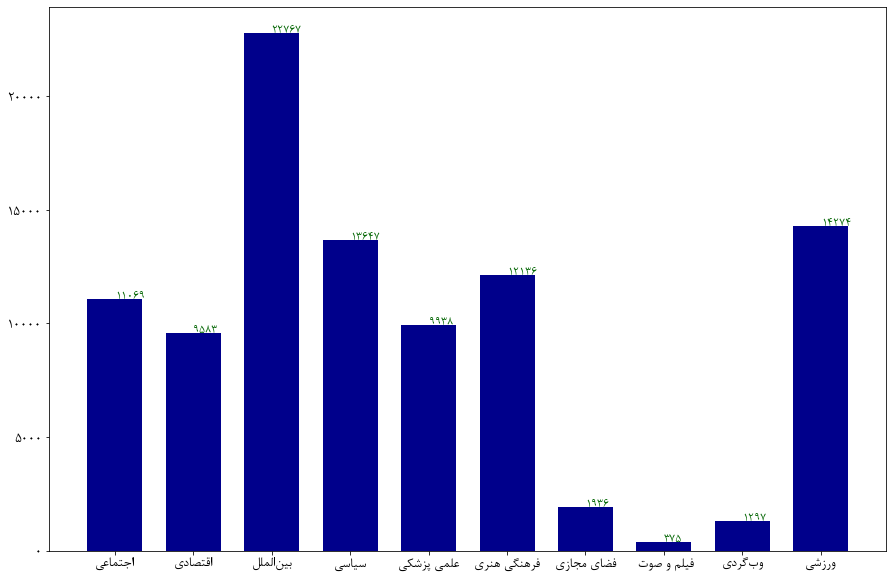

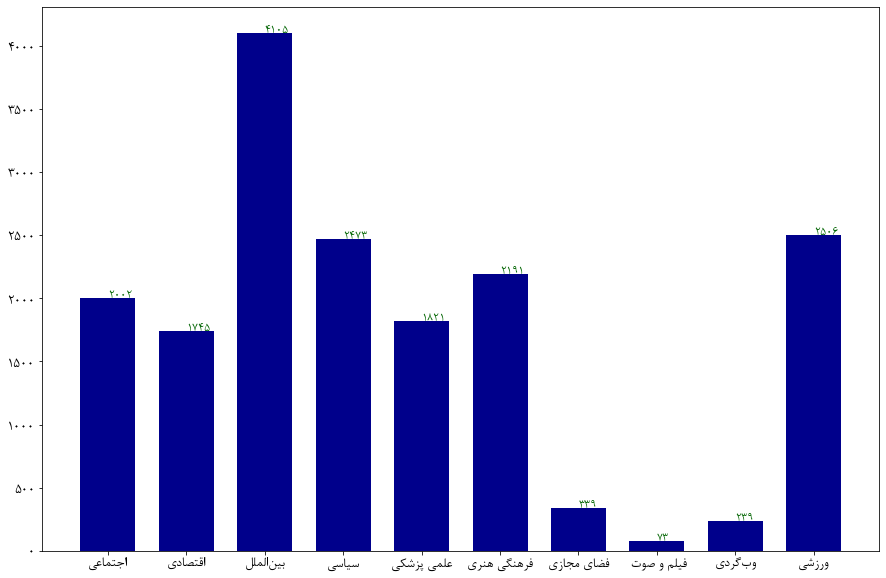

In [3]:
if __name__ == '__main__':
    d = DataPreprocessor()

In [4]:
d.train_data['text'][0]


[6,
 2,
 22,
 1043,
 684,
 7,
 40,
 3,
 2,
 12,
 109,
 393,
 979,
 680,
 16939,
 54,
 257,
 7687,
 4533,
 44237,
 6978,
 4533,
 44237,
 70,
 1051,
 1826,
 35,
 4438,
 180,
 15178,
 3515,
 602,
 7687,
 20189,
 23209,
 602,
 9634,
 213,
 44238,
 6388,
 905,
 2456,
 700,
 6,
 31,
 7687,
 3908,
 223,
 172,
 60,
 847,
 223,
 9,
 486,
 31,
 9427,
 0,
 8132,
 304,
 6979,
 1076,
 555,
 31,
 984,
 7687,
 0,
 1342,
 212,
 7872,
 14235,
 9635,
 3344,
 49614,
 14990,
 8618,
 18497,
 8197,
 28334,
 7340,
 2058,
 35,
 40163,
 3486,
 335,
 223,
 415,
 7687,
 9,
 486,
 368,
 99535,
 3961,
 432,
 436,
 520,
 44,
 7687,
 3063,
 7687,
 480,
 78,
 5596,
 18821,
 807,
 3344,
 576,
 30,
 31,
 5879,
 8248,
 2058,
 764,
 71073,
 31,
 480,
 471,
 791,
 99536,
 315,
 21061,
 49615,
 8408,
 138,
 4213,
 7687,
 31,
 91,
 148,
 555,
 763,
 6692,
 1765,
 6653,
 7687,
 91,
 148,
 58015,
 7264]

In [16]:
d.wordToIndex

{'N': 0,
 'کشور': 1,
 'خبرنگار': 2,
 'باشگاه': 3,
 'ایر': 4,
 'سال': 5,
 'گزار': 6,
 'گروه': 7,
 'کار': 8,
 'قرار': 9,
 'ادامه': 10,
 'آمریکا': 11,
 'جو': 12,
 'ب': 13,
 'مل': 14,
 'ت': 15,
 'اسلام': 16,
 'برنامه': 17,
 'ساز': 18,
 'ریس': 19,
 'تهر': 20,
 'دول': 21,
 'حوزه': 22,
 'اجرا': 23,
 'اشاره': 24,
 'جمهور': 25,
 'حضور': 26,
 'شده_اس': 27,
 'اقتصاد': 28,
 'برگزار': 29,
 'می\u200cکند': 30,
 'شهر': 31,
 'ماه': 32,
 'اظهار': 33,
 'نظر': 34,
 'منطقه': 35,
 'سیاس': 36,
 'پا': 37,
 'توجه': 38,
 'پیا': 39,
 'فرهنگ': 40,
 'دس': 41,
 'دانشگاه': 42,
 'انتخاب': 43,
 'خصوص': 44,
 'فیل': 45,
 'افزا': 46,
 'وزیر': 47,
 'شورا': 48,
 'موضوع': 49,
 'انت': 50,
 'سوریه': 51,
 'مجلس': 52,
 'نیرو': 53,
 'نقل': 54,
 'مدیر': 55,
 'طرح': 56,
 'تولید': 57,
 'ساع': 58,
 'اقدا': 59,
 'اس': 60,
 'سه': 61,
 'درصد': 62,
 'افراد': 63,
 'شرک': 64,
 'مشکل': 65,
 'وزار': 66,
 'خبر': 67,
 'اجتماع': 68,
 'باز': 69,
 'اساس': 70,
 'اصل': 71,
 'قانون': 72,
 'نفر': 73,
 'عل': 74,
 'ایجاد': 75,
 'تصریح': 76,
 'گفتگو': 

In [13]:
[d.wordToIndex.get(d.train_data['text'][0][i]) for i in range(len(d.train_data['text'][0]))]

[6,
 2,
 22,
 1043,
 684,
 7,
 40,
 3,
 2,
 12,
 109,
 393,
 979,
 680,
 16939,
 54,
 257,
 7687,
 4533,
 44237,
 6978,
 4533,
 44237,
 70,
 1051,
 1826,
 35,
 4438,
 180,
 15178,
 3515,
 602,
 7687,
 20189,
 23209,
 602,
 9634,
 213,
 44238,
 6388,
 905,
 2456,
 700,
 6,
 31,
 7687,
 3908,
 223,
 172,
 60,
 847,
 223,
 9,
 486,
 31,
 9427,
 0,
 8132,
 304,
 6979,
 1076,
 555,
 31,
 984,
 7687,
 0,
 1342,
 212,
 7872,
 14235,
 9635,
 3344,
 49614,
 14990,
 8618,
 18497,
 8197,
 28334,
 7340,
 2058,
 35,
 40163,
 3486,
 335,
 223,
 415,
 7687,
 9,
 486,
 368,
 99535,
 3961,
 432,
 436,
 520,
 44,
 7687,
 3063,
 7687,
 480,
 78,
 5596,
 18821,
 807,
 3344,
 576,
 30,
 31,
 5879,
 8248,
 2058,
 764,
 71073,
 31,
 480,
 471,
 791,
 99536,
 315,
 21061,
 49615,
 8408,
 138,
 4213,
 7687,
 31,
 91,
 148,
 555,
 763,
 6692,
 1765,
 6653,
 7687,
 91,
 148,
 58015,
 7264]

In [21]:
def convert(text):
    return [d.wordToIndex.get(text[i]) for i in text]
        

In [5]:
d.train_data.to_pickle('train_dataframe')

In [6]:
d.test_data.to_pickle('test_dataframe')

In [8]:
class CNNClassifier:
    
    train_data = pd.read_pickle('train_dataframe')
    test_data = pd.read_pickle('test_dataframe')
    
    def __init__(self):
        pass
    
    def vectorize(self):
        pass
    
    def define_model(self):
        pass
    
    def train_model(self):
        pass
    
    def predict(self):
        pass
    
    def evaluate(self):
        pass

In [3]:
train_data = pd.read_pickle('train_dataframe')


In [4]:
train_data

,category,text
0,فرهنگی هنری,"[6, 2, 22, 1043, 684, 7, 40, 3, 2, 12, 109, 39..."
1,فرهنگی هنری,"[6, 22, 666, 3, 2, 457, 11203, 2492, 12, 6029,..."
2,فرهنگی هنری,"[6, 22, 467, 3, 2, 54, 166, 153, 78, 238, 1374..."
3,فرهنگی هنری,"[6, 2, 535, 229, 3, 2, 314, 229, 2581, 554, 60..."
4,فرهنگی هنری,"[6, 2, 2072, 160, 7, 40, 3, 2, 12, 676, 255, 2..."
...,...,...
97017,ورزشی,"[6, 7, 45, 4420, 3, 2, 12, 12365, 14641, 19424..."
97018,ورزشی,"[6, 2, 22, 130, 935, 7, 226, 3, 2, 12, 1009, 1..."
97019,ورزشی,"[6, 2, 226, 3, 2, 312, 43, 15, 14, 12805, 0, 8..."
97020,ورزشی,"[6, 2, 130, 935, 7, 226, 3, 2, 12, 15, 130, 26..."


In [5]:
Y = train_data['category']
Y

0        فرهنگی هنری
1        فرهنگی هنری
2        فرهنگی هنری
3        فرهنگی هنری
4        فرهنگی هنری
            ...     
97017          ورزشی
97018          ورزشی
97019          ورزشی
97020          ورزشی
97021          ورزشی
Name: category, Length: 97022, dtype: object

In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
temp = lb.fit_transform(train_data['category'])
print(temp[2])
y = to_categorical(temp)
train_data['category'] = y.tolist()

5


In [7]:
train_data

,category,text
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[6, 2, 22, 1043, 684, 7, 40, 3, 2, 12, 109, 39..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[6, 22, 666, 3, 2, 457, 11203, 2492, 12, 6029,..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[6, 22, 467, 3, 2, 54, 166, 153, 78, 238, 1374..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[6, 2, 535, 229, 3, 2, 314, 229, 2581, 554, 60..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[6, 2, 2072, 160, 7, 40, 3, 2, 12, 676, 255, 2..."
...,...,...
97017,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6, 7, 45, 4420, 3, 2, 12, 12365, 14641, 19424..."
97018,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6, 2, 22, 130, 935, 7, 226, 3, 2, 12, 1009, 1..."
97019,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6, 2, 226, 3, 2, 312, 43, 15, 14, 12805, 0, 8..."
97020,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6, 2, 130, 935, 7, 226, 3, 2, 12, 15, 130, 26..."


In [13]:
from keras.preprocessing.sequence import pad_sequences
max_len = 0
L = [len(i) for i in train_data['text']]
sum(L)/len(L)
padded_sequences = pad_sequences(train_data['text'], maxlen=int(sum(L)/len(L)) + 1)
padded_sequences

array([[    0,     0,     0, ...,   148, 58015,  7264],
       [   23,  2171,  3749, ...,    49,   886,   304],
       [    0,     0,     0, ...,   486,    50,  6791],
       ...,
       [    0,     0,     0, ...,  8247,  2600,    29],
       [  121,  2092,   269, ...,   335,  1764,  3555],
       [ 3564,   385,  1214, ...,   825,  5168,   124]])